In [35]:
import pandas as pd
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import (
    factor_information_coefficient,
    mean_information_coefficient,
)
from alphalens.plotting import (
    plot_ic_ts,
    plot_information_table,
)

In [37]:
# read the cached backtest results into a DataFrame
mean_reversion = pd.read_pickle('D:/AlgoT/Mycode/Event-Based-Testing/mean_reversion.pickle')

In [38]:
# A DataFrame with symbols in the columns and dates in the rows
prices = pd.concat(
    [df.to_frame(d) for d, df in mean_reversion.prices.dropna().items()], axis=1
).T

In [39]:
# convert column names to strings
prices.columns = [col.symbol for col in prices.columns]

In [40]:
# normalize the data
prices.index = prices.index.normalize()

In [41]:
display(prices)

,AAL,AAPL,ABBV,AET,AGN,AIG,AMGN,AMZN,APC,AVGO,...,BBY,EFX,EL,DWDP,SBAC,ANTM,AMT,PCG,CBS,TMO
2016-01-04 00:00:00+00:00,40.91,105.35,57.61,109.26,307.47,60.43,158.34,636.99,49.13,142.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05 00:00:00+00:00,40.91,105.35,57.61,109.26,307.47,60.43,158.34,636.99,49.13,142.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 00:00:00+00:00,40.91,105.35,57.61,109.26,307.47,60.43,158.34,636.99,49.13,142.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07 00:00:00+00:00,40.91,105.35,57.61,109.26,307.47,60.43,158.34,636.99,49.13,142.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08 00:00:00+00:00,40.91,105.35,57.61,109.26,307.47,60.43,158.34,636.99,49.13,142.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 00:00:00+00:00,NaN,176.42,98.19,177.34,170.91,NaN,176.14,1190.58,NaN,264.39,...,NaN,NaN,NaN,71.39,NaN,227.02,NaN,NaN,59.00,NaN
2017-12-26 00:00:00+00:00,NaN,170.57,97.75,180.42,164.44,NaN,176.09,1176.76,NaN,258.10,...,NaN,NaN,NaN,71.44,NaN,225.43,NaN,44.45,60.19,NaN
2017-12-27 00:00:00+00:00,NaN,170.57,97.75,180.42,164.44,NaN,176.09,1176.76,NaN,258.10,...,NaN,NaN,NaN,71.44,NaN,225.43,NaN,44.45,60.19,NaN
2017-12-28 00:00:00+00:00,NaN,170.57,97.75,180.42,164.44,NaN,176.09,1176.76,NaN,258.10,...,NaN,NaN,NaN,71.44,NaN,225.43,NaN,44.45,60.19,NaN


In [42]:
# a DataFrame with symbols in the columns and factor rank in the rows
factor_data = pd.concat(
    [df.to_frame(d) for d, df in mean_reversion.factor_data.dropna().items()], axis=1
).T

In [43]:
# convert column names to strings
factor_data.columns = [
    col.symbol for col in factor_data.columns
]

In [44]:
# normalize the data
factor_data.index = factor_data.index.normalize()

In [45]:
# A MultiIndex with date in level 0 and symbol in level 1
factor_data = factor_data.stack()

In [46]:
# Rename the MultiIndex
factor_data.index.names = ["date", "asset"]

In [47]:
display(factor_data)

date                       asset
2016-01-04 00:00:00+00:00  AAL      1156.0
                           AAPL     2547.0
                           ABBV      438.0
                           AET       893.0
                           AGN      1371.0
                                     ...  
2017-12-29 00:00:00+00:00  ISRG     2449.0
                           DWDP     1277.0
                           ANTM     1510.0
                           PCG      2440.0
                           CBS       292.0
Length: 50275, dtype: float64

In [49]:
# create a MultiIndex Data with foward returns, factor values, and factor quantiles
alphalens_data = get_clean_factor_and_forward_returns(
    factor=factor_data, prices=prices, periods=(5, 10, 21, 63)
)

D:\Anaconda\An\envs\my-quant-stack\lib\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
D:\Anaconda\An\envs\my-quant-stack\lib\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
D:\Anaconda\An\envs\my-quant-stack\lib\site-packages\alphalens\utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or speci

Dropped 12.5% entries from factor data: 12.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [61]:
display(alphalens_data)

5D       10D       21D       63D  \
date                      asset                                           
2016-01-04 00:00:00+00:00 AAL    0.004155 -0.050110 -0.037399  0.041066   
                          AAPL  -0.064737 -0.082487 -0.084670  0.054770   
                          ABBV  -0.064746 -0.045478 -0.055893  0.027773   
                          AET   -0.036061 -0.040454 -0.053908 -0.064800   
                          AGN   -0.026344 -0.050997 -0.080561 -0.097310   
...                                   ...       ...       ...       ...   
2017-09-29 00:00:00+00:00 ADP    0.004595  0.004595  0.004595  0.004595   
                          COL    0.011153  0.024537  0.035920  0.035920   
                          BBY    0.059996  0.089902  0.089902  0.089902   
                          EFX    0.025883  0.068132  0.037301  0.027976   
                          SBAC   0.009967  0.044323  0.044323  0.044323   

                                 factor  factor_quantile  
date                      asset                           
2016-01-04 00:00:00+00:00 AAL    1156.0                3  
                          AAPL   2547.0                5  
                          ABBV    438.0                1  
                          AET     893.0                2  
                          AGN    1371.0                4  
...                                 ...              ...  
2017-09-29 00:00:00+00:00 ADP    1239.0                3  
                          COL    2196.0                4  
                          BBY    2486.0                5  
                          EFX    2501.0                5  
                          SBAC   2390.0                5  

[43995 rows x 6 columns]

In [63]:
# generate the information coefficient for each holding period on each date
ic = factor_information_coefficient(alphalens_data)

In [65]:
display(ic)

,5D,10D,21D,63D
date,,,,
2016-01-04 00:00:00+00:00,-0.248066,-0.284107,-0.140796,-0.106800
2016-01-05 00:00:00+00:00,-0.248066,-0.284107,-0.140796,-0.106800
2016-01-06 00:00:00+00:00,-0.248066,-0.284107,-0.140796,-0.106800
2016-01-07 00:00:00+00:00,-0.248066,-0.284107,-0.182742,-0.106800
2016-01-08 00:00:00+00:00,-0.248066,-0.263740,-0.182742,-0.085559
...,...,...,...,...
2017-09-25 00:00:00+00:00,-0.009765,0.020817,-0.009796,-0.037130
2017-09-26 00:00:00+00:00,-0.009765,0.020817,-0.009796,-0.094793
2017-09-27 00:00:00+00:00,-0.009765,0.020817,-0.009796,-0.094793


In [67]:
# inspect the statistical properties of the IC at each forward return
plot_information_table(ic)

Information Analysis


,5D,10D,21D,63D
IC Mean,0.023,0.031,0.018,0.014
IC Std.,0.186,0.165,0.155,0.166
Risk-Adjusted IC,0.124,0.186,0.116,0.084
t-stat(IC),2.599,3.894,2.426,1.757
p-value(IC),0.010,0.000,0.016,0.080
IC Skew,0.153,0.104,0.530,0.404
IC Kurtosis,-0.247,-0.554,0.246,-0.221


<Axes: >

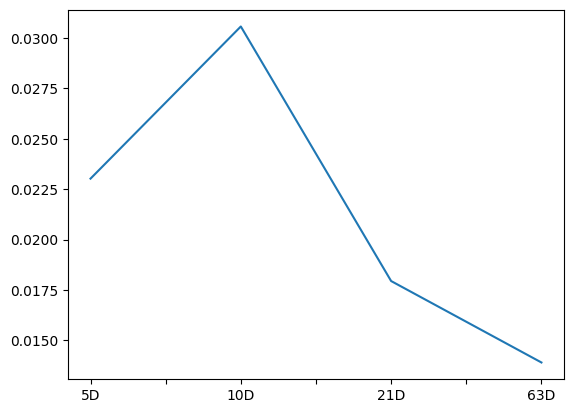

In [69]:
# graph of the IC forward return period to inspect how the alpha decays over 63 days
ic_mean = mean_information_coefficient(alphalens_data)
ic_mean.plot()

array([<Axes: title={'center': '5D Period Forward Return Information Coefficient (IC)'}, ylabel='IC'>],
      dtype=object)

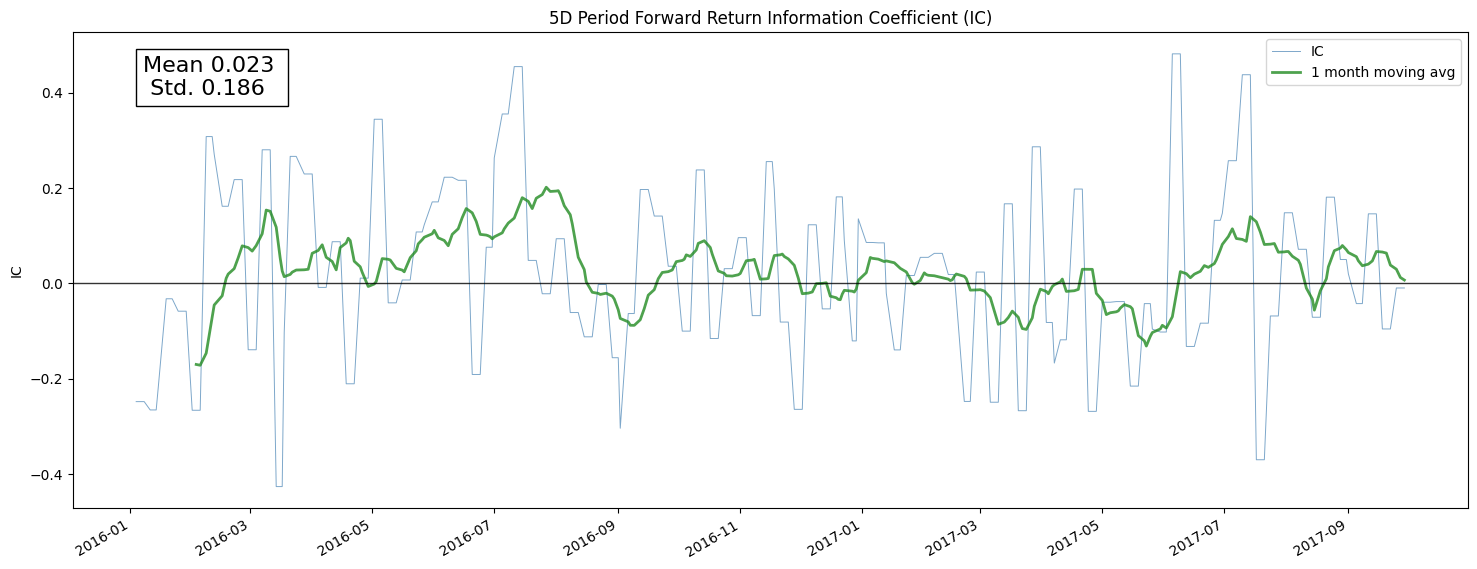

In [71]:
# visualize how IC evolves through time
plot_ic_ts(ic[["5D"]])

In [ ]:
ic_by_quarter = ic.resample("Q").mean()
ic_by_quarter.index = ic_by_quarter.index.to_period("Q")
ic_